# Multiclassifier

Agora vamos ter 3 classes

> Pacientes Controle, Parkinson em estágio avançado, Parkinson em estágio inicial

In [2]:
%load_ext autoreload


In [128]:
import parkinson

import torch
from torch import nn

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

--------------


### Leitura dos Dados

In [4]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')

100%|██████████| 188/188 [00:04<00:00, 44.19it/s]


In [5]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

parkinson_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(parkinson_atlas_data, "pearson")
control_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(control_atlas_data, "pearson")
prodomal_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(prodomal_atlas_data, "pearson")

X = np.concatenate([parkinson_correlation_matrix, prodomal_correlation_matrix, control_correlation_matrix], axis=0)
y = np.concatenate([
    [2 for _ in range(len(parkinson_data))],
    [1 for _ in range(len(prodomal_data))],
    [0 for _ in range(len(control_data))]
], axis=0)

X, y = parkinson.utils.data.filter_data(X, y)

In [6]:
X.shape

(367, 13861)

-----------


### Hiperparâmetros

In [106]:
RANDOM_STATE = 50
N_SPLITS = 5  # Number of folds for cross-validation
TEST_SIZE = 0.2 # Hold-out test set size

# Model Hyperparameters
INPUT_DIM = X.shape[1] # Will be set after data loading
HIDDEN_DIM_1 = 32
HIDDEN_DIM_2 = 16
OUTPUT_DIM = 3
DROPOUT = 0.5

# Training Hyperparameters
NUM_EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 2

----------

### Split dos dados

In [119]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=RANDOM_STATE, stratify=y_trainval, shuffle=True)

In [129]:
scaler = StandardScaler().fit(X_trainval)
X_trainval = scaler.transform(X_trainval)
X_test     = scaler.transform(X_test)

---------------

### Rede Neural Multiclasse

Netword Multiclasse

In [130]:
class MLP_Multiclass(nn.Module):
    def __init__(self, input_dim, h1, h2, output_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(h1),
            nn.Linear(h1, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


----

## Cross Validation

In [122]:
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [123]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

aggregated_preds, aggregated_labels = [], []

In [124]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n===== FOLD {fold+1}/{N_SPLITS} =====")
    
    # --- Data, Model, and Optimizer Setup for Fold ---
    X_train, y_train = X_trainval[train_idx], y_trainval[train_idx]
    X_val, y_val = X_trainval[val_idx], y_trainval[val_idx]
    
    train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, BATCH_SIZE, shuffle=True)
    val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, BATCH_SIZE)
    test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, BATCH_SIZE)

    model = MLP_Multiclass(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, OUTPUT_DIM, DROPOUT).to(device)
    class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

    # --- Training using your library function ---
    # The train function handles the epochs, early stopping, and returns the best model state
    train_output = parkinson.utils.train.train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        class_weights=class_weights,
        num_epochs=NUM_EPOCHS,
        device=device,
        lr=LEARNING_RATE,
        patience=PATIENCE
    )
    
    # --- Evaluation on Test Set ---
    # Load the best model state returned by your train function
    model.eval()
    
    with torch.no_grad():
        fold_preds, fold_labels = [], []
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, 1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(y_batch.cpu().numpy())
    
    print(f"Fold {fold+1} Test Accuracy: {accuracy_score(fold_labels, fold_preds):.4f}")    
    aggregated_preds.extend(fold_preds)
    aggregated_labels.extend(fold_labels)


===== FOLD 1/5 =====


Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

train-loss: 0.6889  train-acc: 0.7949 | val-loss: 1.0305  val-acc: 0.5763:   6%|▌         | 9/150 [00:02<00:40,  3.46it/s]

Early stopping at epoch 10


Fold 1 Test Accuracy: 0.5676

===== FOLD 2/5 =====


train-loss: 0.6682  train-acc: 0.7650 | val-loss: 1.0431  val-acc: 0.4915:   4%|▍         | 6/150 [00:01<00:42,  3.37it/s]

Early stopping at epoch 7


Fold 2 Test Accuracy: 0.5135

===== FOLD 3/5 =====


train-loss: 0.6308  train-acc: 0.7479 | val-loss: 0.9871  val-acc: 0.5593:   7%|▋         | 10/150 [00:02<00:38,  3.61it/s]

Early stopping at epoch 11


Fold 3 Test Accuracy: 0.5270

===== FOLD 4/5 =====


train-loss: 0.5172  train-acc: 0.8383 | val-loss: 0.9778  val-acc: 0.5690:   5%|▌         | 8/150 [00:02<00:40,  3.48it/s]

Early stopping at epoch 9


Fold 4 Test Accuracy: 0.5811

===== FOLD 5/5 =====


train-loss: 0.6898  train-acc: 0.7745 | val-loss: 0.9370  val-acc: 0.6552:   5%|▍         | 7/150 [00:02<00:41,  3.42it/s]

Early stopping at epoch 8


Fold 5 Test Accuracy: 0.6351


In [125]:
print("\n===== Overall Test Set Performance =====")
print(f"Accuracy:  {accuracy_score(aggregated_labels, aggregated_preds):.4f}")
print(f"F1-Score:  {f1_score(aggregated_labels, aggregated_preds, average='weighted'):.4f}")
print(f"Precision: {precision_score(aggregated_labels, aggregated_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(aggregated_labels, aggregated_preds, average='weighted', zero_division=0):.4f}")



===== Overall Test Set Performance =====
Accuracy:  0.5649
F1-Score:  0.5505
Precision: 0.5635
Recall:    0.5649


In [126]:
def plot_confusion_matrix(labels: np.ndarray, preds: np.ndarray) -> None:
    """Plots a confusion matrix using the true and predicted labels."""
    cm = confusion_matrix(labels, preds, labels=[2, 1, 0])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['PD', 'Prodromal', 'Control'], 
                yticklabels=['PD', 'Prodromal', 'Control'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Aggregated Confusion Matrix (from Hold-Out Test Set)')
    plt.show()

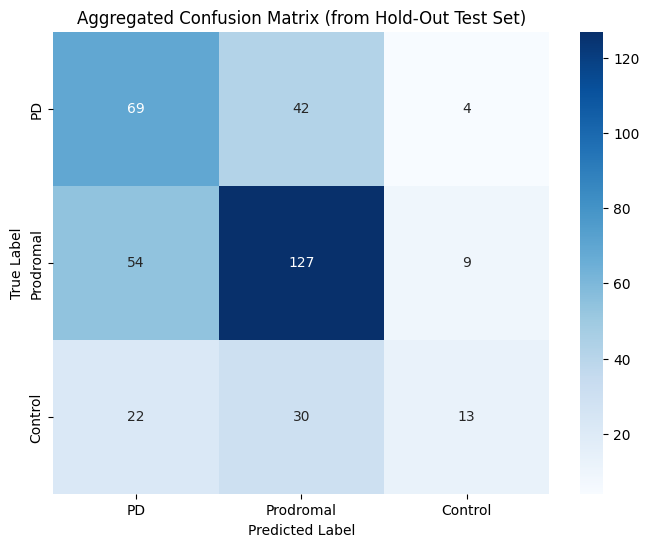

In [127]:
plot_confusion_matrix(np.array(aggregated_labels), np.array(aggregated_preds))



--- Fold 1/5 ---


/tmp/ipykernel_37337/3662879379.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))


Epoch 001 | train_loss=1.1257 val_loss=1.0781 val_f1=0.4325
Epoch 010 | train_loss=0.1488 val_loss=0.9651 val_f1=0.4925
Epoch 020 | train_loss=0.0720 val_loss=1.0706 val_f1=0.5393
Early stopping at epoch 24
>>> Fold 1 Test — acc: 0.5946, f1: 0.5021


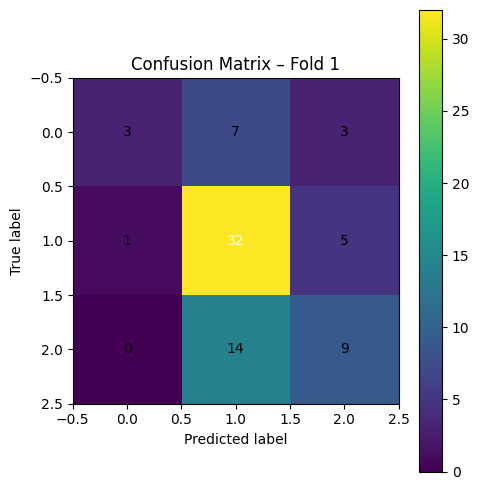


--- Fold 2/5 ---
Epoch 001 | train_loss=1.1462 val_loss=1.0284 val_f1=0.4943


/tmp/ipykernel_37337/3662879379.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))


Epoch 010 | train_loss=0.1627 val_loss=1.0868 val_f1=0.4315
Early stopping at epoch 11
>>> Fold 2 Test — acc: 0.5541, f1: 0.4824


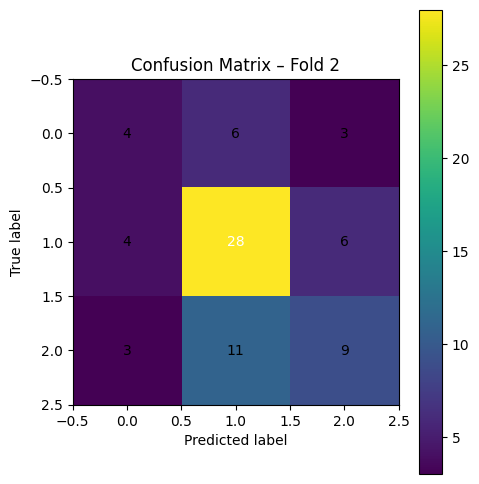


--- Fold 3/5 ---
Epoch 001 | train_loss=1.1741 val_loss=1.1130 val_f1=0.5144


/tmp/ipykernel_37337/3662879379.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))


Epoch 010 | train_loss=0.1716 val_loss=0.8740 val_f1=0.6080
Epoch 020 | train_loss=0.0629 val_loss=0.9135 val_f1=0.5738
Early stopping at epoch 22
>>> Fold 3 Test — acc: 0.6081, f1: 0.5417


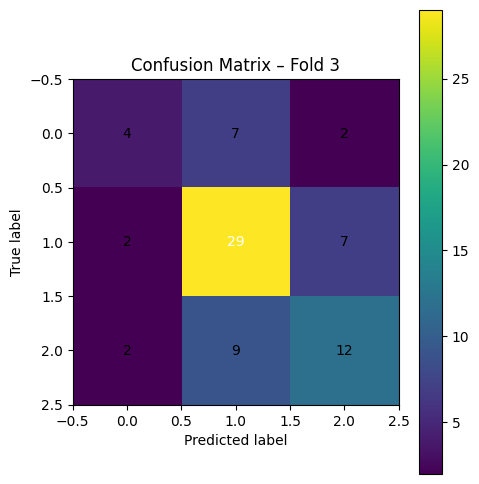


--- Fold 4/5 ---
Epoch 001 | train_loss=1.1613 val_loss=0.9169 val_f1=0.4737


/tmp/ipykernel_37337/3662879379.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))


Epoch 010 | train_loss=0.1820 val_loss=0.8079 val_f1=0.6573
Epoch 020 | train_loss=0.0565 val_loss=0.7870 val_f1=0.7021
Early stopping at epoch 27
>>> Fold 4 Test — acc: 0.6216, f1: 0.5181


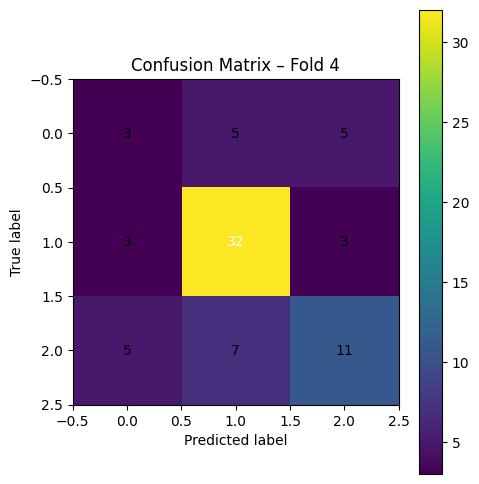


--- Fold 5/5 ---
Epoch 001 | train_loss=1.1794 val_loss=1.0410 val_f1=0.4497


/tmp/ipykernel_37337/3662879379.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))


Epoch 010 | train_loss=0.1537 val_loss=0.8536 val_f1=0.5242
Early stopping at epoch 18
>>> Fold 5 Test — acc: 0.5541, f1: 0.4813


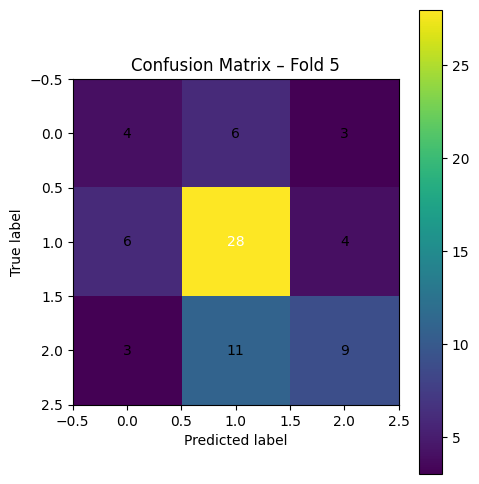


Overall:  Accuracy = 0.5865 ± 0.0278
          Macro-F1  = 0.5051 ± 0.0228


In [136]:
import os
import random
import itertools
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tqdm import tqdm

# 1) Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2) Hyperparameters
N_SPLITS      = 5
BATCH_SIZE    = 32
LR            = 1e-3
EPOCHS        = 100
PATIENCE      = 10
HIDDEN_DIMS   = [256, 128]
DROPOUT       = 0.5
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES   = 3  # control, prodromal, PD-advanced

# (… data loading, Fisher‐Z, vectorization, scaling as before …)
def make_loader(X, y, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, drop_last=False)

# 6) Model definition
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(hidden_dims)):
            layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout),
            ]
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# (… train_one_epoch and eval_model as before …)

# 8) Cross-Validation with Confusion Matrix plotting
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_metrics = []

for fold, (tr_idx, vl_idx) in enumerate(skf.split(X_trainval, y_trainval), 1):
    print(f"\n--- Fold {fold}/{N_SPLITS} ---")
    X_tr, y_tr = X_trainval[tr_idx], y_trainval[tr_idx]
    X_vl, y_vl = X_trainval[vl_idx], y_trainval[vl_idx]

    train_loader = make_loader(X_tr, y_tr, shuffle=True)
    val_loader   = make_loader(X_vl, y_vl, shuffle=False)
    test_loader  = make_loader(X_test, y_test, shuffle=False)

    model = MLP(
        input_dim   = X_tr.shape[1],
        hidden_dims = HIDDEN_DIMS,
        output_dim  = NUM_CLASSES,
        dropout     = DROPOUT
    ).to(DEVICE)

    class_weights = parkinson.utils.data.get_torch_class_weights(y_tr)
    criterion     = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=DEVICE))
    optimizer     = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    best_val_f1 = 0
    epochs_no_improve = 0

    for epoch in range(1, EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_f1, *_ = eval_model(model, val_loader, criterion)
        scheduler.step(val_loss)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state  = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} "
                  f"val_loss={val_loss:.4f} val_f1={val_f1:.4f}")

    model.load_state_dict(best_state)

    # final test eval
    test_loss, test_acc, test_f1, test_prec, test_rec, y_true, y_pred = eval_model(model, test_loader, criterion)
    print(f">>> Fold {fold} Test — acc: {test_acc:.4f}, f1: {test_f1:.4f}")
    fold_metrics.append((test_acc, test_f1))

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix – Fold {fold}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# 9) Aggregate & report
accs, f1s = zip(*fold_metrics)
print(f"\nOverall:  Accuracy = {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"          Macro-F1  = {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
